In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import re
from adjustText import adjust_text
plt.style.use('ggplot')

pd.options.display.max_columns = 999
pd.options.display.max_rows = 300
np.set_printoptions(linewidth=400)
%matplotlib inline
from IPython.display import display, HTML
pd.options.mode.chained_assignment = None
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
players = pd.read_csv("CompleteDataset.csv")
player_att = pd.read_csv("PlayerAttributeData.csv") #to get att names easier
players["Preferred Positions 1"] = players["Preferred Positions"].apply(lambda x: re.findall('^([\w\-]+)', x)[0])
# if fowards 0, midfield = 1, defender = 2, GK = 3
positions_map1 = {
 'CAM': 1,
 'CB': 2,
 'CDM': 2,
 'CF': 0,
 'CM': 1,
 'GK': 3,
 'LB': 2,
 'LM': 1,
 'LW': 0,
 'LWB': 2,
 'RB': 2,
 'RM': 1,
 'RW': 0,
 'RWB': 2,
 'ST': 0}

players["Preferred Positions int"] = players["Preferred Positions 1"].replace(positions_map1)
players = players.fillna(players.mean())

/Users/matt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/matt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def get_attributes(players):
    attribute_names = player_att.columns[1:].values
    attribute_names = attribute_names[attribute_names!="ID"]
    attributes = players[attribute_names]
    attributes = attributes.apply(pd.to_numeric, errors='coerce', axis=0)
    attributes = attributes.fillna(attributes.mean())
    return attributes

attributes = get_attributes(players)
position_col = players["Preferred Positions int"]

In [4]:
def dim_reduction(x):
    dim_reduce = PCA(n_components=2)
    dim_reduce_fit = dim_reduce.fit_transform(x)
    return dim_reduce, dim_reduce_fit

In [5]:
def biplot(dim_reduce,coeff,labels=None,color="blue",alpha=0.5):
    fig, ax = plt.subplots(figsize=(20,20))
    xs = dim_reduce[:,0]
    ys = dim_reduce[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    cax = ax.scatter(xs*scalex,ys*scaley,c = color,alpha=0.35)
    arrow_scale = 1.3
    annotations = []
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0]*arrow_scale, coeff[i,1]*arrow_scale,color = 'red',linestyle="-",alpha=0.5)
        annotations.append(ax.text(coeff[i,0]*arrow_scale, coeff[i,1]*arrow_scale, labels[i], color = 'black', ha = 'left', va = 'top',fontsize=15))
    adjust_text(annotations)
    ax.set_xlabel("First component")
    ax.set_ylabel("Second component")
    return fig,cax


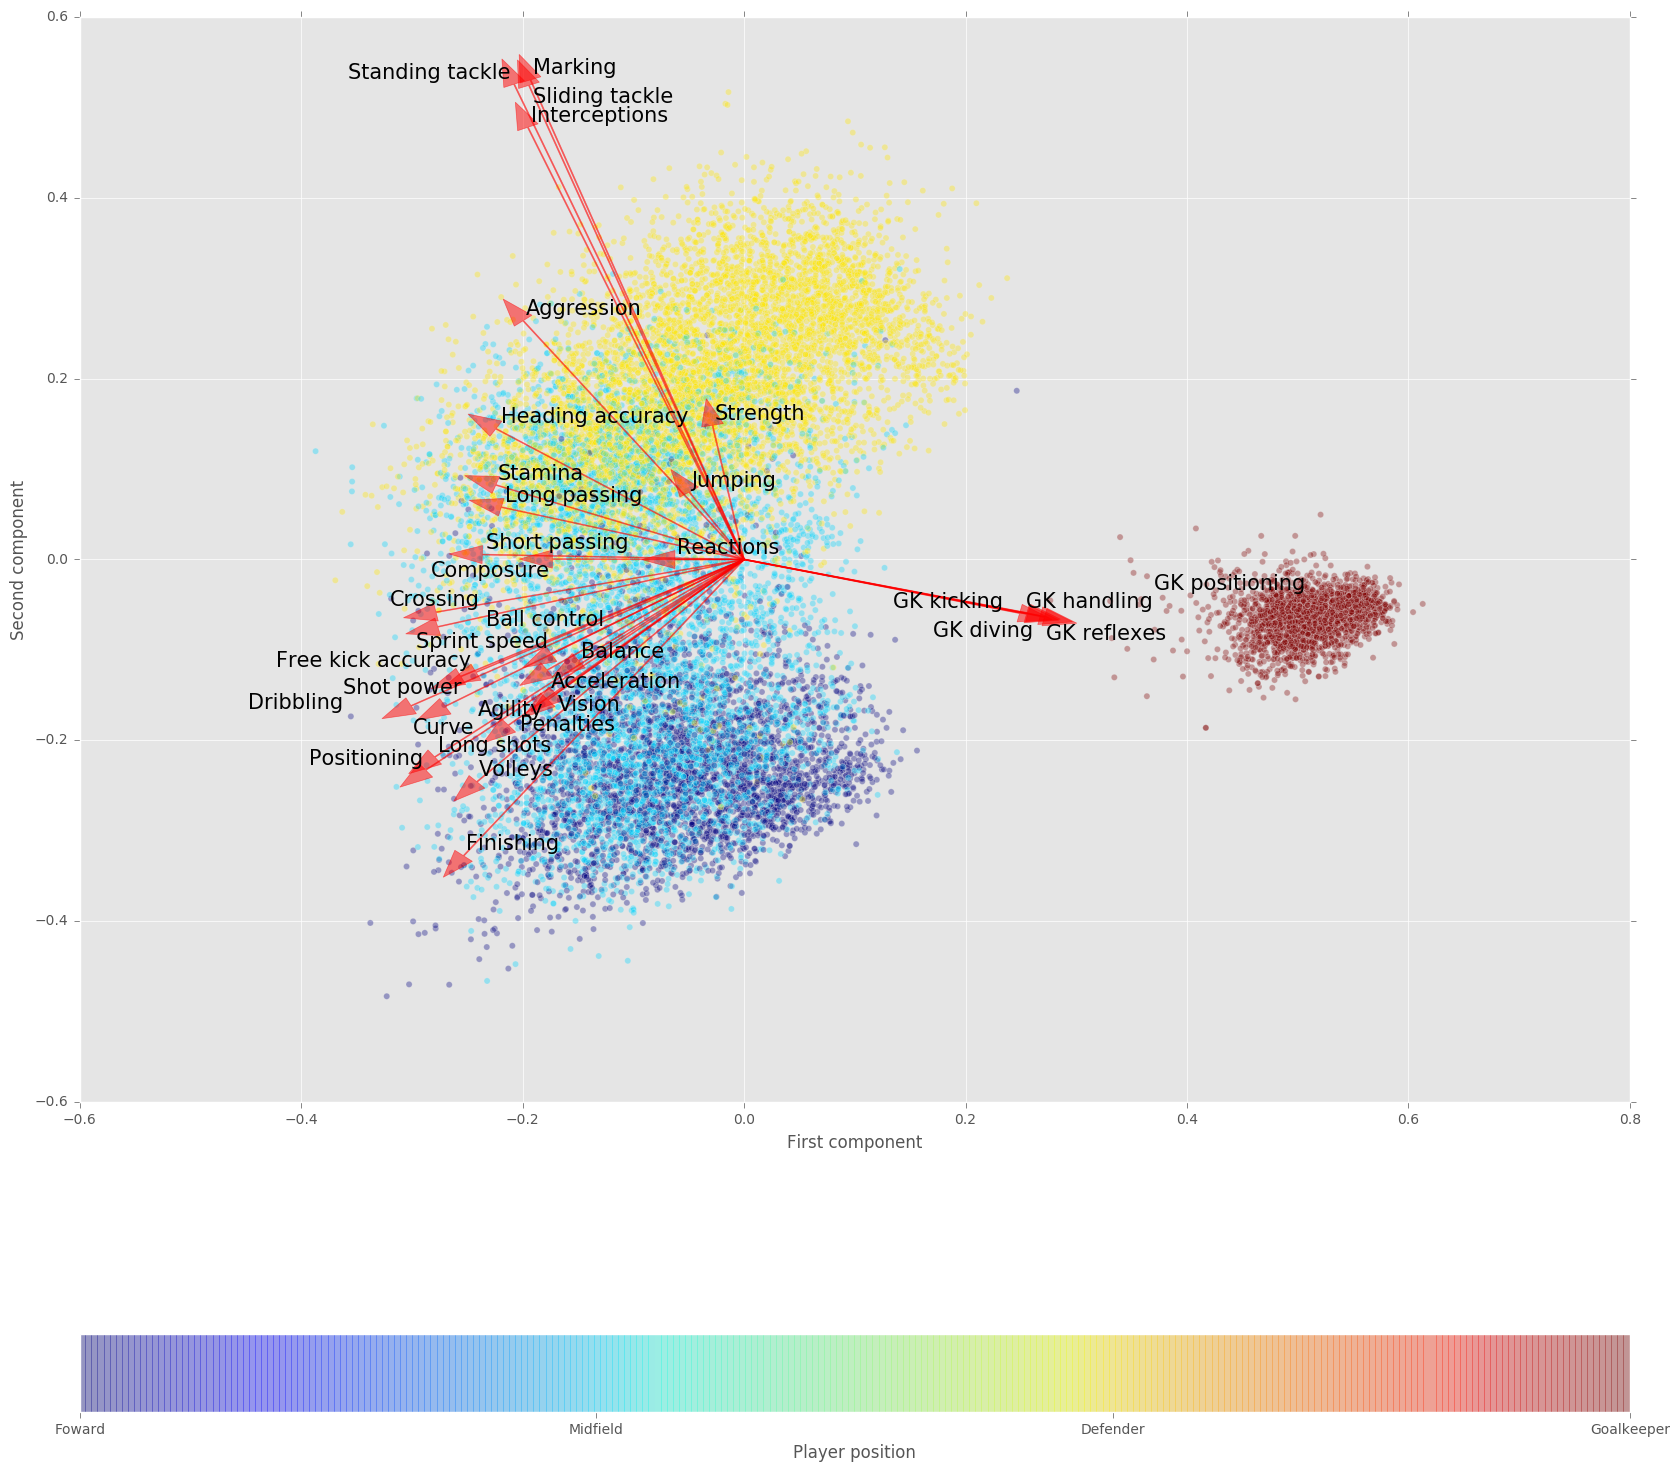

In [6]:
dim_reduce, dim_reduce_fit = dim_reduction(attributes)
fig,cax = biplot(dim_reduce_fit,np.transpose(dim_reduce.components_[0:2, :]),labels= attributes.columns.values,color=position_col)
cbar = fig.colorbar(cax, ticks=[0,1,2,3], orientation='horizontal')
cbar.ax.set_xticklabels(['Foward','Midfield','Defender',"Goalkeeper"])  # horizontal colorbar
cbar.set_label("Player position")
plt.savefig("fifa_by_position.png")
plt.show()

# Remove GoalKeepers and look at log wages

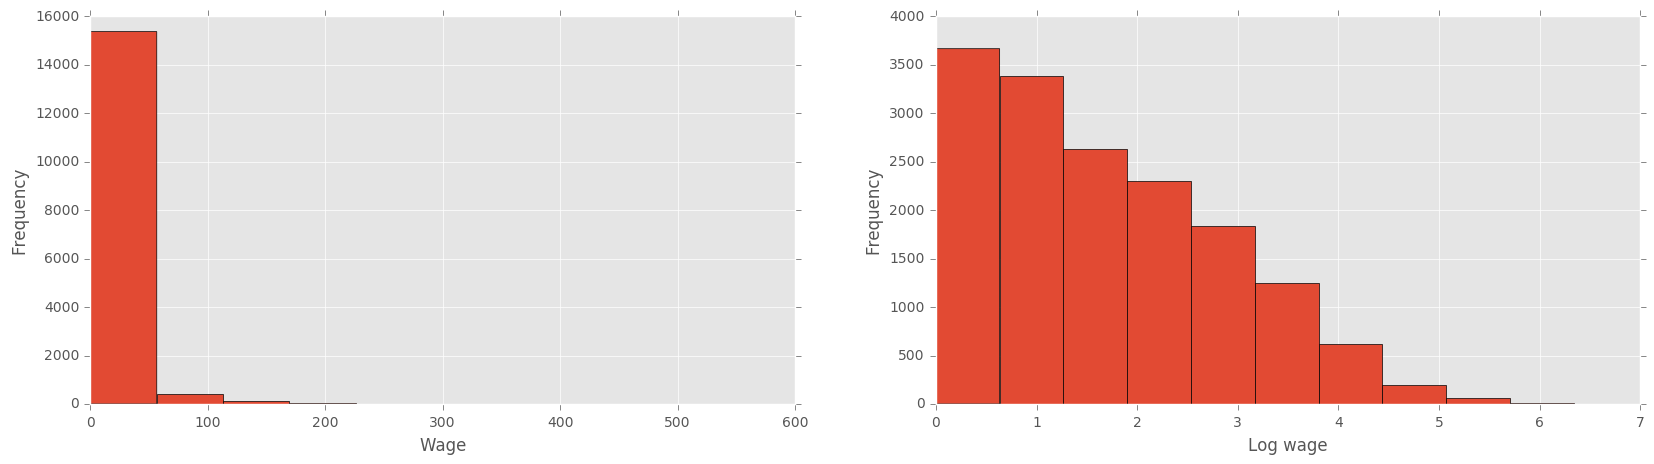

In [7]:
no_gks = players.loc[players["Preferred Positions 1"]!="GK"]
no_gks["Wage"] = no_gks["Wage"].replace('[\€K,]', '', regex=True).astype(float)
no_gks["Wage log"] = no_gks["Wage"].apply(np.log)
no_gks["Wage log"] = no_gks["Wage log"].fillna(0)
no_gks["Wage log"][np.isinf(no_gks["Wage log"])] = 0 #some people have negative wages :S. set them to zero
attributes = get_attributes(no_gks)
dim_reduce, dim_reduce_fit = dim_reduction(attributes)
wage_col = no_gks["Wage log"]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax1.hist(no_gks["Wage"],bins=10,edgecolor = "k"); ax1.set_xlabel("Wage"); ax1.set_ylabel("Frequency");
ax2.hist(no_gks["Wage log"],bins=10,edgecolor = "k"); ax2.set_ylabel("Frequency"); ax2.set_xlabel("Log wage")
plt.show()

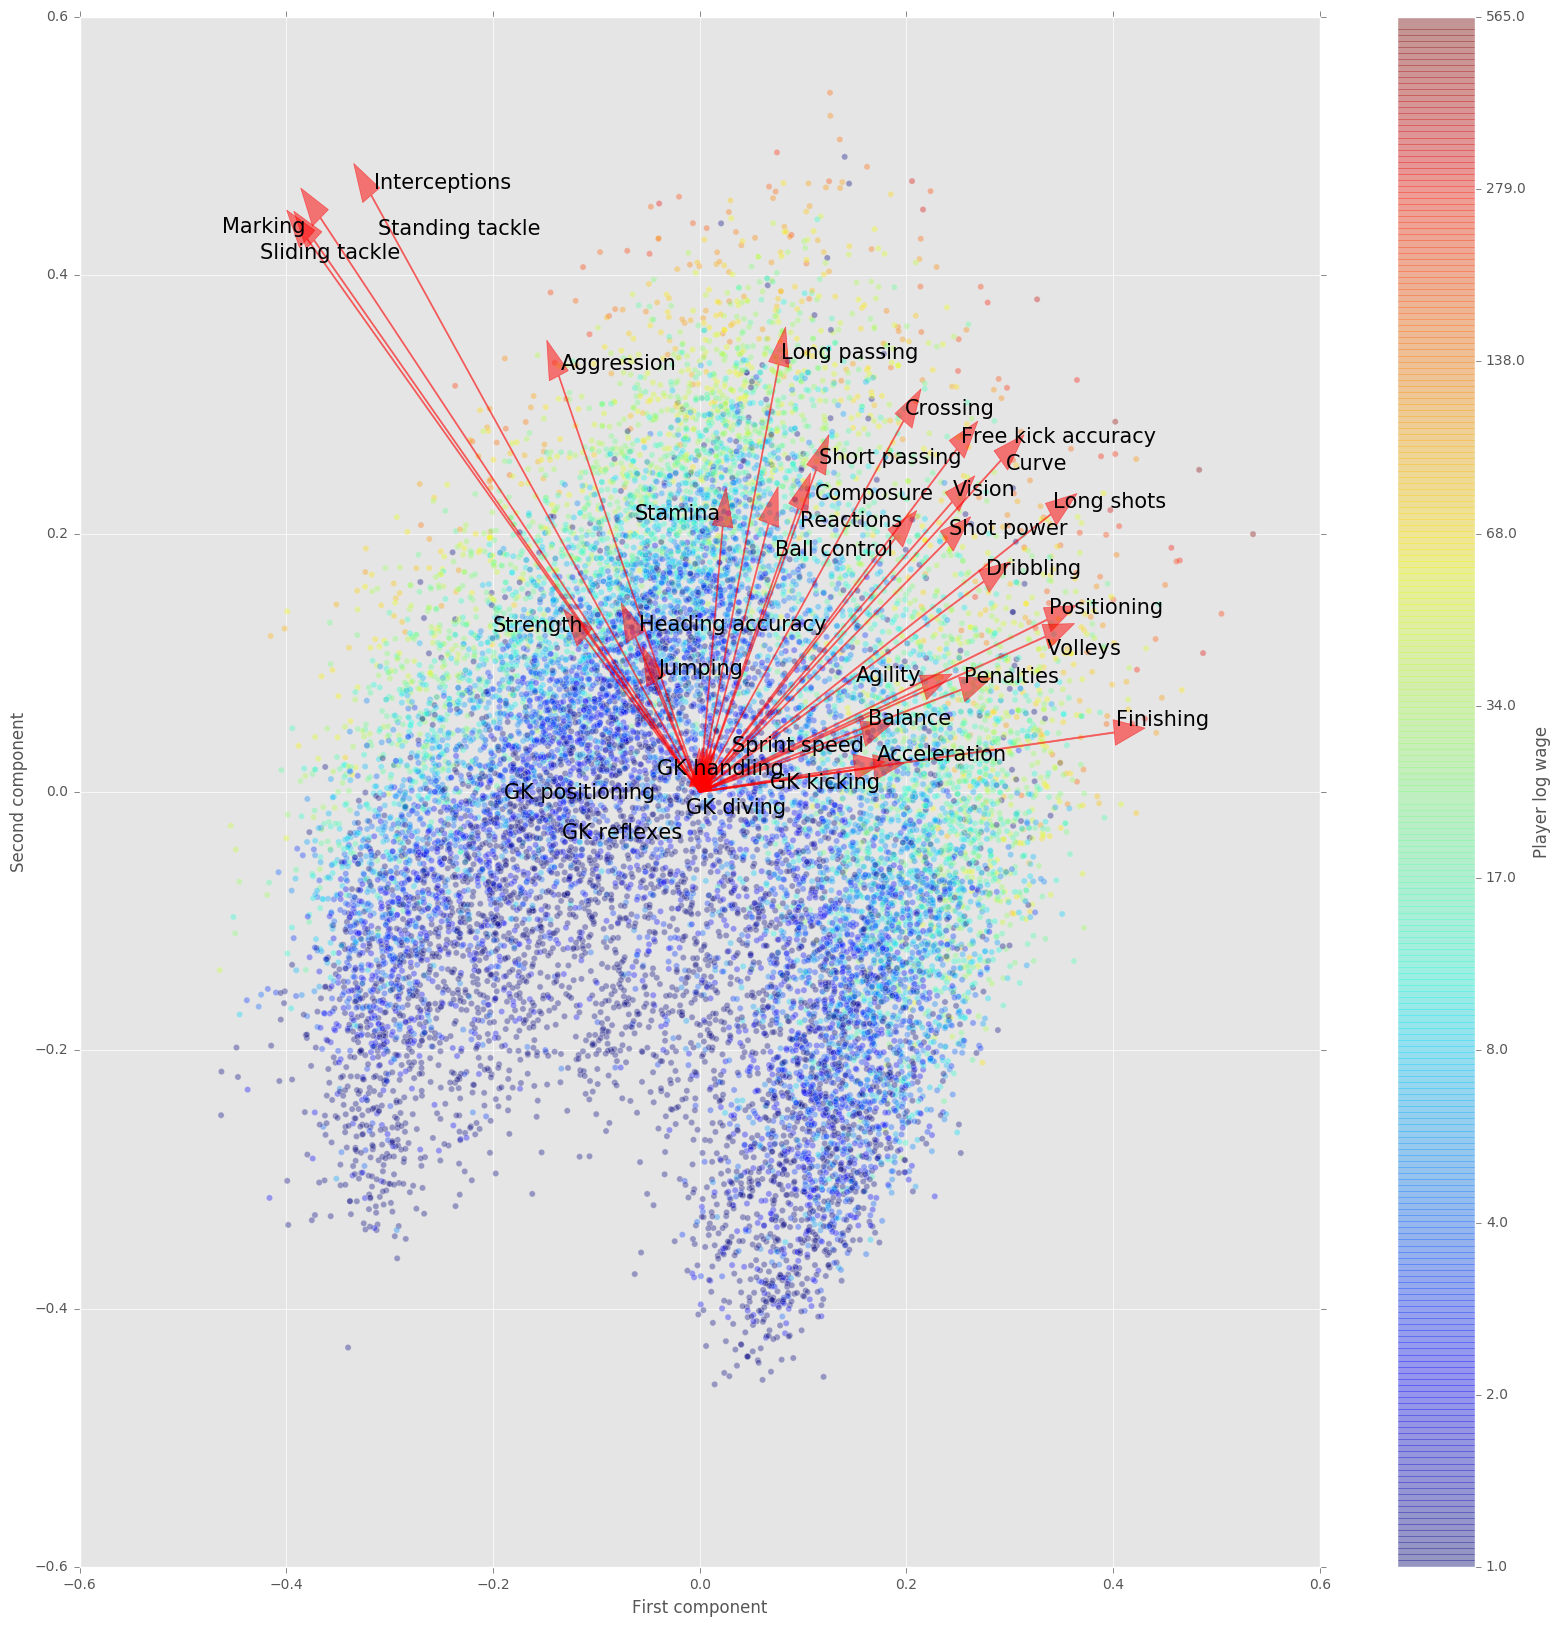

In [8]:
fig, cax = biplot(dim_reduce_fit,np.transpose(dim_reduce.components_[0:2, :]),labels=attributes.columns.values,color=wage_col,alpha=0.9)
ticks = np.linspace(0,wage_col.max(),10)
cbar = fig.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(np.exp(ticks).round())  # vertically oriented colorbar
cbar.set_label("Player log wage")
plt.savefig("fifa_by_lwage.png")
plt.show()